# Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers, optimizers
from keras.callbacks import Callback
import kmapper as km
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
import gudhi as gd

# Data

### MNIST podatkovni set  
- Vsebuje slike ročno napisanih številk velikosti **28×28 pik**  
- Za ta eksperiment smo podatke **filtrirali tako, da vključujejo le števki 3 in 5**

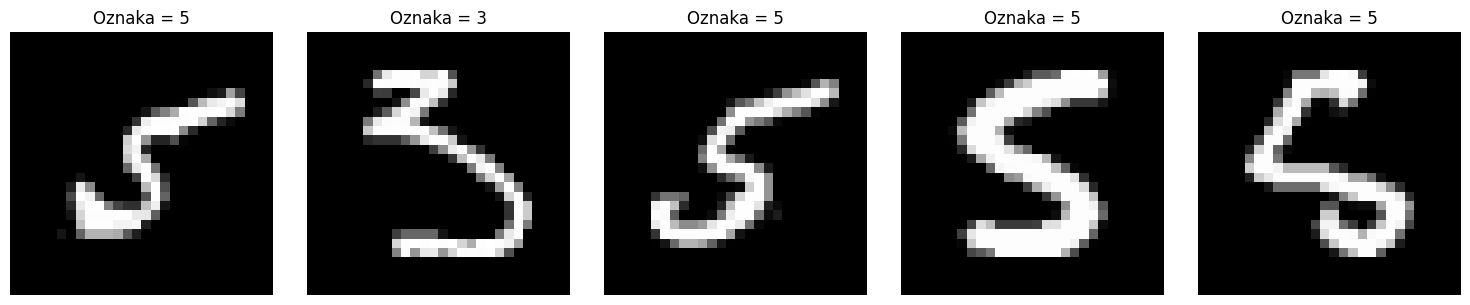

In [2]:
# Naložimo podatkovni set
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Pomožna funkcija za filtriranje
def filter_digits(X, y, digits=(3, 5)):
    mask = np.isin(y, digits)
    return X[mask], y[mask]

# Filtriranje podatkov
X_train, y_train = filter_digits(X_train, y_train, digits=(3, 5))
X_test, y_test = filter_digits(X_test, y_test, digits=(3, 5))

# Primeri podatkov
fig = plt.figure(figsize=(15, 3))
rows, columns = 1, 5

# Izbremo 5 naključnih slik
random_indices = np.random.choice(len(X_train), size=5, replace=False)

for i, idx in enumerate(random_indices, 1):
    fig.add_subplot(rows, columns, i)
    img = X_train[idx]

    plt.imshow(img, cmap='gray')
    plt.title(f'Oznaka = {y_train[idx]}')
    plt.axis('off')

plt.tight_layout()

# Preprocessing

In [3]:
# Normalizacija
X_train, X_test = X_train / 255.0, X_test / 255.0

# Pretvorba slik v vektorje pixlov
pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape(X_train.shape[0], pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], pixels).astype('float32')
print('Train shape: {}\nTest shape: {}'.format(X_train.shape, X_test.shape))

# Ponovna označitev: 3 → 0, 5 → 1
y_train = (y_train == 5).astype(int)
y_test = (y_test == 5).astype(int)

# Kodiranje oznak v one-hot vektorje
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

Train shape: (11552, 784)
Test shape: (1902, 784)


# Nevronska mreža

In [4]:
def train_model(X_train, 
                y_train, 
                X_test, 
                y_test,
                neurons,
                init=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=42),
                activation='sigmoid', 
                l1=0.0, 
                l2=0.0, 
                loss='categorical_crossentropy', 
                learning_rate=0.01,
                epochs=5, 
                batch_size=100, 
                training_steps=500):
    
    activ = [activation]*(len(neurons)-2)+['softmax']

    model = Sequential()
    for n in range(1, len(neurons)):
        model.add(Dense(neurons[n],
                    input_dim=neurons[n-1], 
                    kernel_initializer=init,
                    use_bias=False,
                    activation=activ[n-1]))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(learning_rate=learning_rate, momentum=0.0, decay=0.0, nesterov=False),
                  metrics=['accuracy'])

    # Train model
    training_steps = training_steps    # Desired number of training steps (approximate)
    N_ws = round((len(X_train) * epochs) / (batch_size * training_steps))
    WSaver = SaveWeights(N_ws)  # not SaveWeights(model, N_ws)


    calback_list = [WSaver]
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=batch_size, callbacks=calback_list, verbose=2)
    scores = model.evaluate(X_test, y_test, verbose=0)

    W_layer = {}
    for n in range(len(model.layers)):
        W_layer[n] = WSaver.weights_layer[n]
    steps = len(W_layer[0])
    # Lists of vectors of weights for each neuron for each training step
    X_layer = {}
    for n in range(len(model.layers)):
        X_layer[n] = np.squeeze([W_layer[n][i][:, [j]] for i in range(steps) for j in range(neurons[n+1])])
    # Labels = [neuron number, training step]
    y_layer = {}
    for n in range(len(model.layers)):
        y_layer[n] = np.array([[j, i] for i in range(steps) for j in range(neurons[n+1])])
    # Number of weight matrices saved = 1 + (60000 * epochs) / (batch_size * N_ws)
    print('Training steps: {}'.format(steps))

    # Plot training and validation accuracy (and loss)
    plt.figure(figsize=(15, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return W_layer, X_layer, y_layer

# Callback function to save weights after each N mini-batches

class SaveWeights(Callback):
    def __init__(self, N):
        super().__init__()
        self.N = N
        self.batch = 0
        self.weights_layer = {}

    def set_model(self, model):
        super().set_model(model)  # ✅ This sets the read-only 'model' attribute

    def on_train_begin(self, logs=None):
        for n in range(len(self.model.layers)):
            self.weights_layer[n] = [self.model.layers[n].get_weights()[0]]

    def on_batch_end(self, batch, logs=None):
        if self.batch % self.N == 0:
            for n in range(len(self.model.layers)):
                self.weights_layer[n].append(self.model.layers[n].get_weights()[0])
        self.batch += 1


# Testiranje

Epoch 1/70


/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


116/116 - 0s - 2ms/step - accuracy: 0.6409 - loss: 0.6603 - val_accuracy: 0.5852 - val_loss: 0.6157
Epoch 2/70
116/116 - 0s - 722us/step - accuracy: 0.8466 - loss: 0.5401 - val_accuracy: 0.8360 - val_loss: 0.4516
Epoch 3/70
116/116 - 0s - 708us/step - accuracy: 0.9026 - loss: 0.3676 - val_accuracy: 0.9027 - val_loss: 0.2899
Epoch 4/70
116/116 - 0s - 702us/step - accuracy: 0.9254 - loss: 0.2514 - val_accuracy: 0.9416 - val_loss: 0.2005
Epoch 5/70
116/116 - 0s - 705us/step - accuracy: 0.9346 - loss: 0.1991 - val_accuracy: 0.9474 - val_loss: 0.1629
Epoch 6/70
116/116 - 0s - 701us/step - accuracy: 0.9382 - loss: 0.1734 - val_accuracy: 0.9506 - val_loss: 0.1421
Epoch 7/70
116/116 - 0s - 723us/step - accuracy: 0.9416 - loss: 0.1581 - val_accuracy: 0.9532 - val_loss: 0.1341
Epoch 8/70
116/116 - 0s - 712us/step - accuracy: 0.9445 - loss: 0.1483 - val_accuracy: 0.9553 - val_loss: 0.1229
Epoch 9/70
116/116 - 0s - 702us/step - accuracy: 0.9465 - loss: 0.1411 - val_accuracy: 0.9564 - val_loss: 0.1

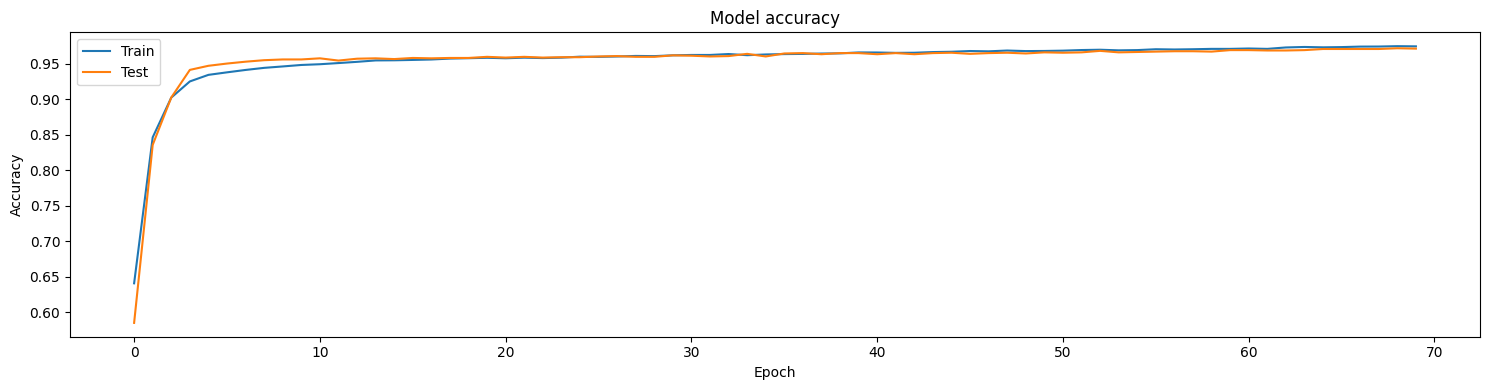

In [5]:
# Inicializiramo uteži
init = initializers.GlorotUniform(seed=42)

# Arhitektura nevronske mreže
neurons = [pixels, 100, 100, 2]

# Train 
W_layer, X_layer, y_layer = train_model(X_train, y_train, X_test, y_test,
                                        neurons=neurons,
                                        init=init,
                                        activation='sigmoid',
                                        loss='categorical_crossentropy',
                                        l1=0.0, l2=0.0, 
                                        learning_rate=0.05,
                                        epochs=70, 
                                        batch_size=100,
                                        training_steps=200)

### Vizualizacija uteži v prostoru PCA

Uteži iz vsake plasti nevronske mreže smo preslikali v dvodimenzionalni prostor s pomočjo **PCA (Principal Component Analysis)**, da bi lažje razumeli njihovo porazdelitev in evolucijo skozi učenje.

- **Vsaka točka predstavlja en nevron** ob določenem učnem koraku.
- Barva točke označuje bodisi:
  - **učni korak** (leva slika), ali
  - **identiteto nevrona** (desna slika).

#### V zadnjem sloju:
- **Nevron 0** predstavlja slike števila **3**
- **Nevron 1** predstavlja slike števila **5**


/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/majal/Razvijam/

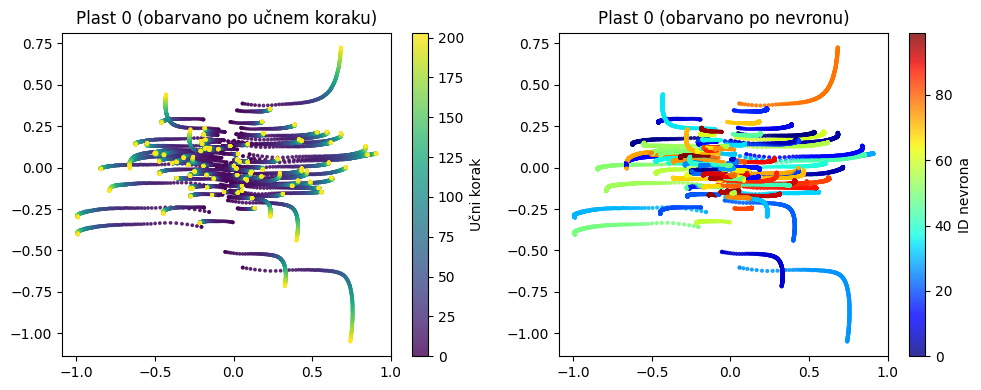

/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/majal/Razvijam/

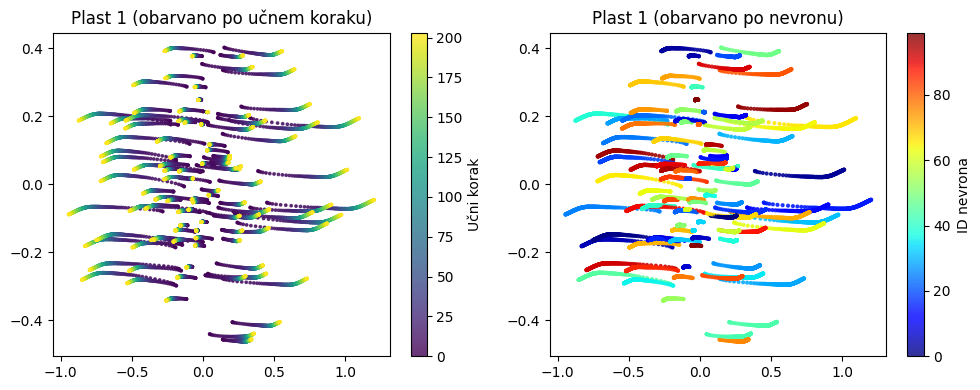

/var/folders/mw/_62t3vrx42ncwgtc0tkl749m0000gn/T/ipykernel_89034/2099463660.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
/var/folders/mw/_62t3vrx42ncwgtc0tkl749m0000gn/T/ipykernel_89034/2099463660.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('jet'), alpha=0.8)


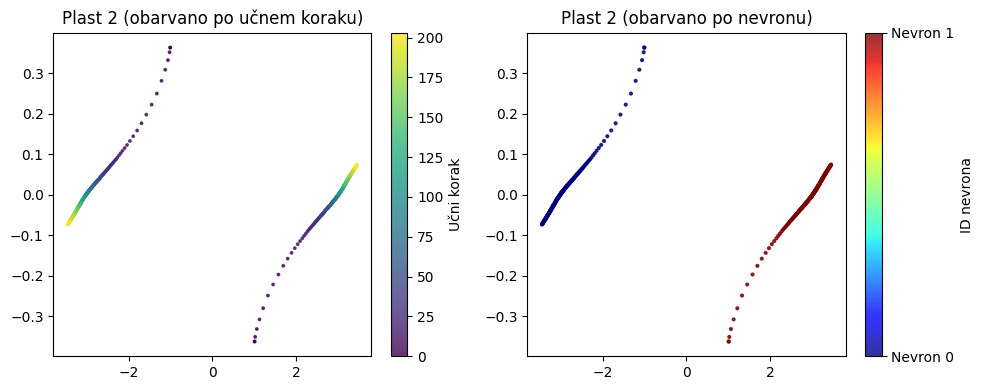

In [6]:
for lay_num in range(len(X_layer)):
    X_pca2 = PCA(n_components=2).fit_transform(X_layer[lay_num])
    
    plt.figure(figsize=(10, 4))
    
    # colored by training step
    plt.subplot(121)
    scatter1 = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], s=3, c=y_layer[lay_num][:, 1],
                           cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
    plt.title(f'Plast {lay_num} (obarvano po učnem koraku)')
    plt.colorbar(scatter1, label="Učni korak")

    # colored by neuron ID
    plt.subplot(122)
    scatter2 = plt.scatter(X_pca2[:, 0], X_pca2[:, 1], s=4, c=y_layer[lay_num][:, 0],
                           cmap=plt.cm.get_cmap('jet'), alpha=0.8)
    plt.title(f'Plast {lay_num} (obarvano po nevronu)')

    # Add colorbar with neuron labels
    cbar = plt.colorbar(scatter2)
    cbar.set_label("ID nevrona")

    # Diskretne labele nevronov prikažemo samo v zadnjem koraku
    if lay_num == len(X_layer) - 1:
        neuron_ids = np.unique(y_layer[lay_num][:, 0])
        cbar.set_ticks(neuron_ids)
        cbar.set_ticklabels([f"Nevron {int(n)}" for n in neuron_ids])

    plt.tight_layout()
    plt.show()


### Mapper

In [7]:
def graph_km(data, 
             label, 
             path, 
             projection=PCA(3), 
             title='Title', 
             color_function='Step', 
             nr_cubes=45, 
             overlap_perc=0.09, 
             clusterer=DBSCAN(eps=0.3, min_samples=15)):
    
    # Initialize KeplerMapper (used for lens only)
    mapper = km.KeplerMapper(verbose=1)

    # Create the projection (lens)
    lens = mapper.fit_transform(data, projection=projection, scaler=None)

    # Create the simplicial complex
    graph = mapper.map(lens,
                data,
                cover=km.Cover(nr_cubes, overlap_perc),  
                clusterer=clusterer)
    
    # Color values function
    if color_function == 'Class': 
        color_func = label[:,0]
        color_func_name = "Obarvano po nevronu"
    elif color_function == 'Step':
        color_func = label[:,1]
        color_func_name = "Obarvano po učnem koraku"


    html = mapper.visualize(graph,
                            path_html=path,
                            title=title,
                            color_values=color_func,
                            color_function_name=color_func_name)

Brez zmanjševanja dimenzij

PCA

In [8]:
lay_num = 0
proj = PCA(2)
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/PCA_Graph_{}.html'.format(lay_num))
IPython.display.IFrame('output/PCA_Graph_{}.html'.format(lay_num), 800, 600)

/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/majal/Razvijam/

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: PCA(n_components=2)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20400, 784)

..Projecting data using: 
	PCA(n_components=2)

Mapping on data shaped (20400, 784) using lens shaped (20400, 2)

Creating 2025 hypercubes.

Created 275 edges and 346 nodes in 0:00:00.483328.
Wrote visualization to: output/PCA_Graph_0.html


In [9]:
lay_num = 1
proj = PCA(2)
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/PCA_Graph_{}.html'.format(lay_num))
IPython.display.IFrame('PCA_Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: PCA(n_components=2)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20400, 100)

..Projecting data using: 
	PCA(n_components=2)

Mapping on data shaped (20400, 100) using lens shaped (20400, 2)

Creating 2025 hypercubes.


/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/majal/Razvijam/


Created 329 edges and 382 nodes in 0:00:00.349536.
Wrote visualization to: output/PCA_Graph_1.html


In [10]:
lay_num = 2
proj = PCA(2)
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/PCA_Graph_{}.html'.format(lay_num))
IPython.display.IFrame('output/PCA_Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: PCA(n_components=2)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (408, 100)

..Projecting data using: 
	PCA(n_components=2)

Mapping on data shaped (408, 100) using lens shaped (408, 2)

Creating 2025 hypercubes.

Created 2 edges and 12 nodes in 0:00:00.019715.
Wrote visualization to: output/PCA_Graph_2.html


TSNE

In [11]:
lay_num = 0
proj = TSNE(n_components=2)
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/TSNE_Graph_{}.html'.format(lay_num))
IPython.display.IFrame('TSNE_Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20400, 784)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20400 samples in 0.003s...
[t-SNE] Computed neighbors for 20400 samples in 1.662s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20400
[t-SNE] Computed conditional probabilities for sample 2000 / 20400
[t-SNE] Computed conditional probabilities for sample 3000 / 20400
[t-SNE] Computed conditional probabilities for sample 4000 / 20400
[t-SNE] Computed conditional probabilities for sample 5000 / 20400
[t-SNE] Computed conditional probabilities for sample 6000 / 20400
[t-SNE] Computed conditional probabilities for sample 7000 / 20400
[t-SNE] Computed conditional probabilities for sample 8000 / 20400
[t-SNE] Computed conditional probabilities for sample 9000 / 20400
[t-SNE] Computed conditional probabil

/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/majal/Razvijam/topo-learnin

[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.824821
[t-SNE] KL divergence after 1000 iterations: 0.420538
Mapping on data shaped (20400, 784) using lens shaped (20400, 2)

Creating 2025 hypercubes.

Created 515 edges and 598 nodes in 0:00:00.645889.
Wrote visualization to: output/TSNE_Graph_0.html


In [12]:
lay_num = 1
proj = TSNE(n_components=2)
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/TSNE_Graph_{}.html'.format(lay_num))
IPython.display.IFrame('TSNE_Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20400, 100)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20400 samples in 0.000s...
[t-SNE] Computed neighbors for 20400 samples in 0.357s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20400
[t-SNE] Computed conditional probabilities for sample 2000 / 20400
[t-SNE] Computed conditional probabilities for sample 3000 / 20400
[t-SNE] Computed conditional probabilities for sample 4000 / 20400
[t-SNE] Computed conditional probabilities for sample 5000 / 20400
[t-SNE] Computed conditional probabilities for sample 6000 / 20400
[t-SNE] Computed conditional probabilities for sample 7000 / 20400
[t-SNE] Computed conditional probabilities for sample 8000 / 20400
[t-SNE] Computed conditional probabilities for sample 9000 / 20400
[t-SNE] Computed conditional probabil

/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/majal/Razvijam/topo-learnin

[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.705612
[t-SNE] KL divergence after 1000 iterations: 0.418129
Mapping on data shaped (20400, 100) using lens shaped (20400, 2)

Creating 2025 hypercubes.

Created 509 edges and 594 nodes in 0:00:00.561433.
Wrote visualization to: output/TSNE_Graph_1.html


In [13]:
lay_num = 2
proj = TSNE(n_components=2)
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/TSNE_Graph_{}.html'.format(lay_num),
         clusterer=DBSCAN(eps=1.0, min_samples=2))
IPython.display.IFrame('TSNE_Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: TSNE()
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (408, 100)

..Projecting data using: 
	TSNE(verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.000s...
[t-SNE] Computed neighbors for 408 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 0.056476
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.048813


/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/majal/Razvijam/topo-learnin

[t-SNE] KL divergence after 1000 iterations: 0.114643
Mapping on data shaped (408, 100) using lens shaped (408, 2)

Creating 2025 hypercubes.

Created 61 edges and 98 nodes in 0:00:00.053609.
Wrote visualization to: output/TSNE_Graph_2.html


L2 norm

In [14]:
lay_num = 0
proj = 'l2norm'
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/L2_Graph_{}.html'.format(lay_num))
IPython.display.IFrame('L2_Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20400, 784)

..Projecting data using: l2norm
Mapping on data shaped (20400, 784) using lens shaped (20400, 1)

Creating 45 hypercubes.

Created 190 edges and 288 nodes in 0:00:00.563598.
Wrote visualization to: output/L2_Graph_0.html


In [15]:
lay_num = 1
proj = 'l2norm'
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/L2_Graph_{}.html'.format(lay_num))
IPython.display.IFrame('L2_Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20400, 100)

..Projecting data using: l2norm
Mapping on data shaped (20400, 100) using lens shaped (20400, 1)

Creating 45 hypercubes.

Created 265 edges and 365 nodes in 0:00:00.202794.
Wrote visualization to: output/L2_Graph_1.html


In [16]:
lay_num = 2
proj = 'l2norm'
graph_km(X_layer[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer',
         path='output/L2_Graph_{}.html'.format(lay_num))
IPython.display.IFrame('L2_Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (408, 100)

..Projecting data using: l2norm
Mapping on data shaped (408, 100) using lens shaped (408, 1)

Creating 45 hypercubes.

Created 2 edges and 6 nodes in 0:00:00.007269.
Wrote visualization to: output/L2_Graph_2.html


In [17]:
lay_num = 2
X = X_layer[lay_num] 

# Izračunamo vztrajno homologijo
vr = VietorisRipsPersistence(homology_dimensions=[0, 1])  # H0, H1
diagrams = vr.fit_transform([X])

plot_diagram(diagrams[0])

/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/majal/Razvijam/topo-learning/topo-learning/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in ma

In [18]:
X = X_layer[2]

# Create the RipsComplex
rips_complex = gd.RipsComplex(points=X, max_edge_length=2.0)

# Create a simplex tree (filtration)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# Compute persistence
diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=0.01)

Text(0.5, 1.0, 'Persistence Barcode')

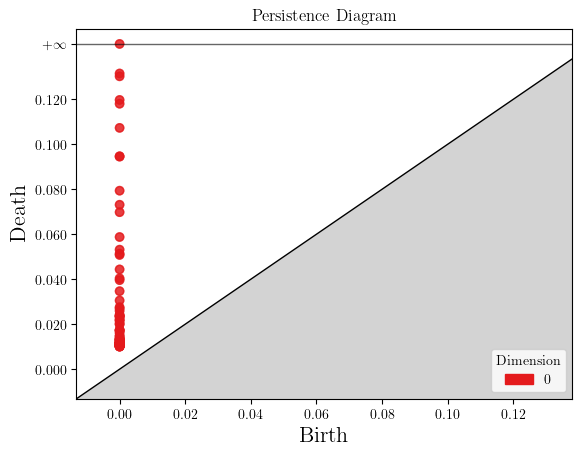

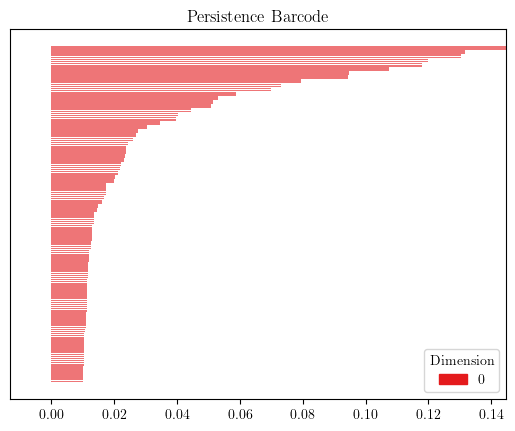

In [19]:
# Plot persistence diagram
gd.plot_persistence_diagram(diag)
plt.title("Persistence Diagram")

# Plot barcode
gd.plot_persistence_barcode(diag)
plt.title("Persistence Barcode")